# tfp on JAX tutorial

Note: I tried the tfp_on_jax with google-env and received the error
```
ImportError: cannot import name 'bijectors' from partially initialized module 'tensorflow_probability.substrates.jax' (most likely due to a circular import) (/home/ww347/.conda/envs/google-env/lib/python3.10/site-packages/tensorflow_probability/substrates/jax/__init__.py)
```
So will move on for now.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

In [2]:
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap

In [3]:
import jax
import tensorflow_probability as tfp
import tensorflow

2024-10-16 14:47:17.340951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 14:47:17.959273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 14:47:18.223391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 14:47:38.073136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# previously had 
# 0.3.25
# 2.11.0
# 0.19.0

In [5]:
print(jax.__version__)
print(tensorflow.__version__)
print(tfp.__version__)

0.4.34
2.17.0
0.24.0


Following tutorial at https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX

In [6]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [8]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[1]
num_classes = len(iris.target_names)

## Demo: Bayesian logistic regression

In [13]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                             sample_shape=(num_features, num_classes)))
    b = yield Root(
        tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,)))
    logits = jnp.dot(features, w) + b
    yield tfd.Independent(tfd.Categorical(logits=logits),
                          reinterpreted_batch_ndims=1)
    
dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
    return dist.log_prob(params + (labels,))

AttributeError: module 'matplotlib.pyplot' has no attribute 'slabel'

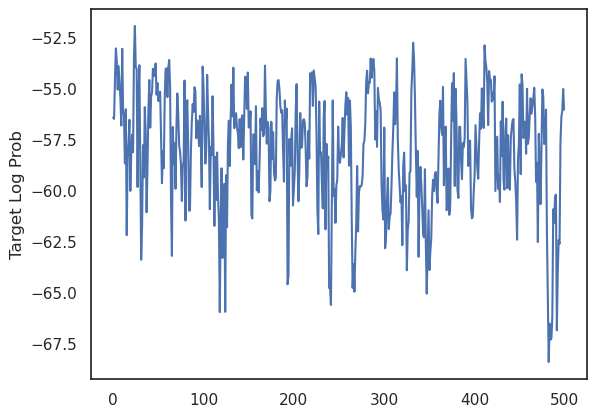

In [14]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
                                 current_state=state,
                                 kernel=kernel,
                                 trace_fn=lambda _, results: results.target_log_prob,
                                 num_burnin_steps=500,
                                 seed=key)
    
states, log_probs = run_chain(sample_key, init_params)

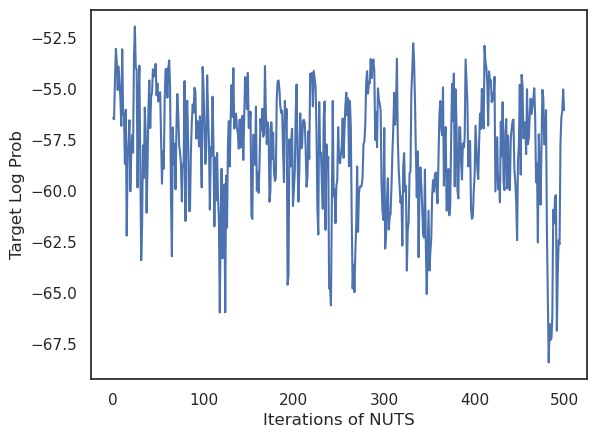

In [15]:
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()